In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.lines as mlines
import seaborn as sns
from intercluster.plotting import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this aside from font.size
# To get tex working on linux run the following:
# `sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super`
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 18
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)



subset_colors = [cmap(0), cmap(5), cmap(1), cmap(3), cmap(6), cmap(7)]
cmap_subset = ListedColormap(subset_colors)

no_oblique_subset_colors = [cmap(0), cmap(5), cmap(1), cmap(6), cmap(7)]
no_oblique_cmap_subset = ListedColormap(no_oblique_subset_colors)

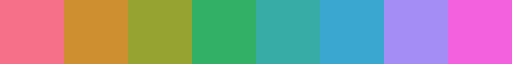

In [58]:
cmap

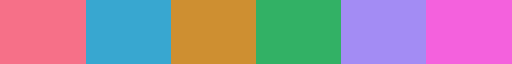

In [59]:
cmap_subset

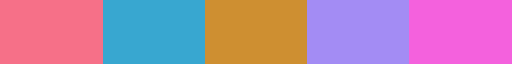

In [56]:
no_oblique_cmap_subset

### Coverage-Cost Experiments

In [74]:
fname = "../data/experiments/anuran/coverage_exp.csv"
experiment_df = pd.read_csv(fname, header=[0, 1, 2], index_col=0)

In [75]:
# Computing statistics:
grouped = experiment_df.T.groupby(level = [0,1])
mean_df = grouped.mean().T
std_df = grouped.std().T

In [76]:
table_df = mean_df.iloc[0,:].to_frame()
table_df

0
coverage                      ExKMC-Forest        0.771666
                              Forest              0.542467
                              Forest-Depth-4      0.546542
                              IMM                 1.000000
                              KMeans              1.000000
                              SVM                 0.565258
distance-ratio                ExKMC-Forest        1.027102
                              Forest              1.177324
                              Forest-Depth-4      1.260144
                              IMM                      NaN
                              KMeans                   NaN
                              SVM                 1.164461
normalized-clustering-cost    ExKMC-Forest       14.526864
                              Forest              6.626005
                              Forest-Depth-4      5.136094
                              IMM                 8.666325
                              KMeans              7.210445
                              SVM                 8.162461
overlap                       ExKMC-Forest        1.000000
                              Forest              1.019424
                              Forest-Depth-4      1.000537
                              IMM                 1.000000
                              KMeans              1.000000
                              SVM                 1.055339
point-average-clustering-cost ExKMC-Forest    81426.566298
                              Forest          25855.846460
                              Forest-Depth-4  20185.413088
                              IMM             62354.208136
                              KMeans          51879.152765
                              SVM             33143.390404
rule-length                   ExKMC-Forest       11.820000
                              Forest              2.000000
                              Forest-Depth-4      4.000000
                              IMM                 8.000000
                              KMeans                   NaN
                              SVM                 1.000000

### Plotting

In [77]:
colormap = no_oblique_cmap_subset
baseline_list = ['KMeans', 'IMM']
module_list = [m for m in mean_df['normalized-clustering-cost'].columns if m not in baseline_list]

(0.0, 1.0, 0.0, 1.0)

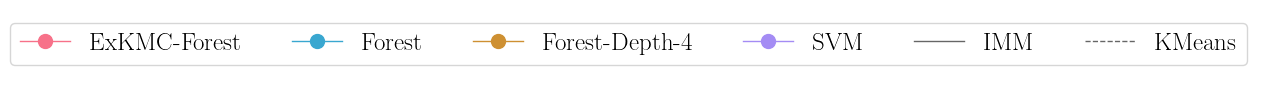

In [78]:
# Legend:
fig, ax = plt.subplots(figsize = (6,1))
legend_elements = [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=10,
        color=colormap(i),
        lw=1,
        label=mod,
        alpha=1
    )
    for i,mod in enumerate(module_list)
]

legend_elements += [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=0,
        color='k',
        lw=1,
        linestyle = '-',
        label="IMM",
        alpha=0.6
    )
]

legend_elements += [
    mlines.Line2D(
        [], [],
        marker = 'o',
        markersize=0,
        color='k',
        lw=1,
        linestyle = 'dashed',
        label="KMeans",
        alpha=0.6
    )
]

ax.legend(handles=legend_elements, ncol=len(module_list) + len(baseline_list))
ax.axis('off')
#plt.savefig('../figures/climate/coverage_legend.png', bbox_inches = 'tight', dpi = 300)

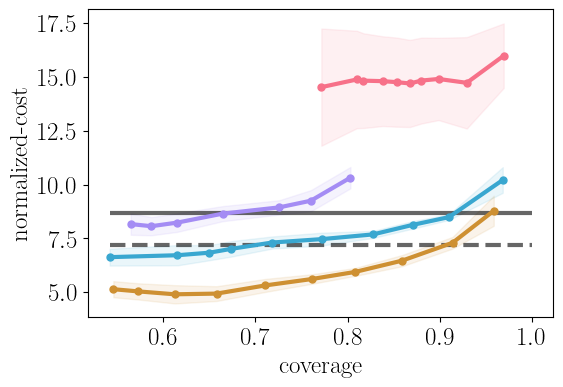

In [80]:
fname = None
fname = '../figures/anuran/normalized_cost.png'
experiment_plotter(
    mean_df['normalized-clustering-cost'],
    std_df['normalized-clustering-cost'],
    domain_df = mean_df['coverage'],
    xlabel = 'coverage',
    ylabel = 'normalized-cost',
    cmap = colormap,
    baseline_list = ['KMeans', 'IMM'],
    legend = False,
    filename = fname,
)
#plt.ylim(10,18)

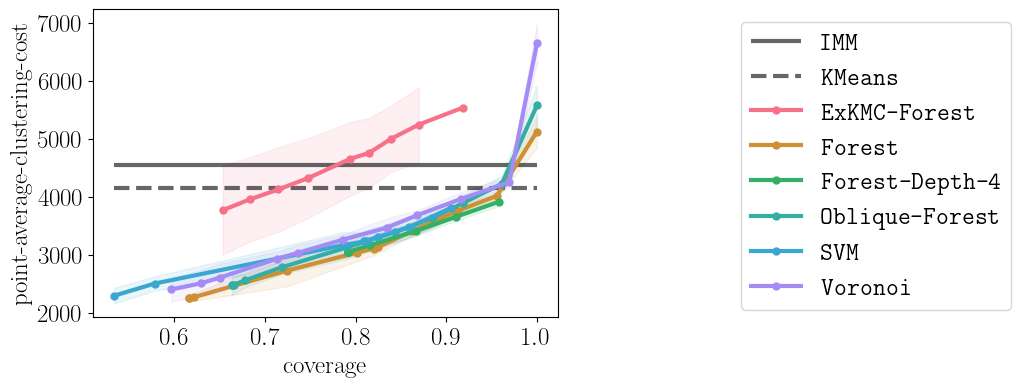

In [21]:
variable = 'point-average-clustering-cost'
fname = None
#fname = '../figures/climate/'
experiment_plotter(
    mean_df[variable],
    std_df[variable],
    xlabel = 'coverage',
    ylabel = variable,
    domain = mean_df['coverage'],
    cmap = cmap_subset,
    legend = True,
    filename = fname,
    baseline_list = ['KMeans', 'IMM']
)
#plt.ylim(10,15)

In [17]:
mean_df['distance-ratio']

,ExKMC-Forest,Forest,Forest-Depth-5,IMM,KMeans,SVM-Forest,Voronoi-Set
0,inf,1.638676,1.495841,1.594826,1.596493,inf,1.592836
1,inf,1.638676,1.495841,1.594826,1.596493,inf,1.592836
2,inf,1.613986,1.495841,1.594826,1.596493,1.749947,1.592836
3,inf,1.599610,1.495841,1.594826,1.596493,1.680446,1.592836
4,inf,1.590175,1.495841,1.594826,1.596493,1.625645,1.588021
5,inf,1.584477,1.495841,1.594826,1.596493,1.605630,1.571792
6,inf,1.544779,1.547680,1.594826,1.596493,1.574870,1.548586
7,inf,1.521701,1.546777,1.594826,1.596493,1.514120,1.506670
8,inf,1.498935,1.512124,1.594826,1.596493,1.391058,1.488403
9,inf,1.499270,1.455912,1.594826,1.596493,NaN,1.427247


### Covered Cost

In [53]:
df = pd.read_csv("../data/experiments/decision_sets/rules_cost_comparison_climate.csv", header=[0, 1, 2], index_col=0)
grouped = df.T.groupby(level = [0,1])
mean_df2 = grouped.mean().T
std_df2 = grouped.std().T

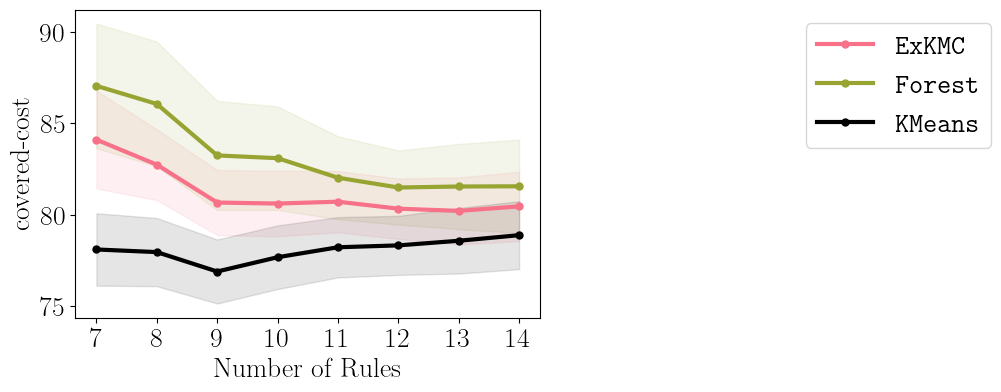

In [61]:
covered_cost_colors = [cmap(0), cmap(2), 'black']
covered_cost_colormap = ListedColormap(covered_cost_colors)

fname = None
fname = '../figures/climate/forest_covered_cost.png'
experiment_plotter(
    mean_df2['point-average-clustering-cost'],
    std_df2['point-average-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'covered-cost',
    domain = list(range(k, 2*k + 1)),
    cmap = covered_cost_colormap,
    legend = True,
    filename = fname,
    baseline_list = []
)

In [59]:
df = pd.read_csv("../data/experiments/decision_sets/rules_cost_comparison_climate_depth_5.csv", header=[0, 1, 2], index_col=0)
grouped = df.T.groupby(level = [0,1])
mean_df3 = grouped.mean().T
std_df3 = grouped.std().T

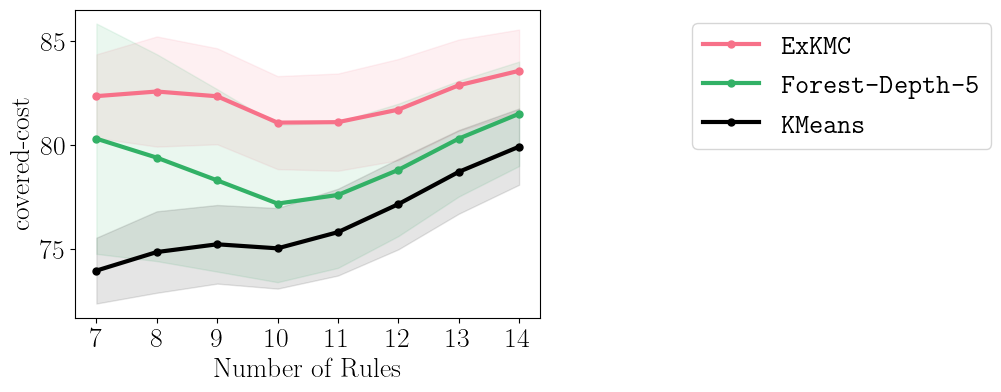

In [62]:
covered_cost_colors = [cmap(0), cmap(3), 'black']
covered_cost_colormap2 = ListedColormap(covered_cost_colors)

fname = None
fname = '../figures/climate/forest_d5_covered_cost.png'
experiment_plotter(
    mean_df3['point-average-clustering-cost'],
    std_df3['point-average-clustering-cost'],
    xlabel = 'Number of Rules',
    ylabel = 'covered-cost',
    domain = list(range(k, 2*k + 1)),
    cmap = covered_cost_colormap2,
    legend = True,
    filename = fname,
    baseline_list = []
)